# **Multi-Class Classification (Excluding Text Features)**

-------
### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, precision_score

-------
## Reading in the Listings Dataset

In [2]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [3]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,reviews_per_month,city,state,zip_codes,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0.29,Boston,Massachusetts,2128,1.0,0,31,3,1,3
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0.90,Boston,Massachusetts,2119,1.0,0,30,4,1,2


------
# **Modeling**

In [4]:
# building a simple model to gauge performance
features = ['amenities_count', 'host_response_time', 
            'host_response_rate', 'host_has_profile_pic','accommodates','license',
            'reviews_per_month', 'host_verifications_count'] # intentionally not including price, didn't appear to be strong predictor of rating based on EDA

# define X and y
X = listings[features]
y = listings['rating_target']

In [5]:
# establishing the baseline accuracy
print(y.value_counts())
print('*'*45)
print(y.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y.value_counts(normalize=True))[2]*100, 2)}%')


2    2713
1    2681
3    2647
4    2623
Name: rating_target, dtype: int64
*********************************************
2    0.254407
1    0.251407
3    0.248218
4    0.245968
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 25.44%


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(7998, 8)
(2666, 8)


## Scale and fit Basic KNN

In [7]:
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [8]:
# instantiate and fit KNNeighbors model with defaults
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)

print(f'training accuracy: {knn.score(X_train_sc, y_train)}')
print(f'test accuracy: {knn.score(X_test_sc, y_test)}')

training accuracy: 0.6415353838459615
test accuracy: 0.45723930982745686


## Fit basic Multinomial Logistic Regression

In [9]:
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train, y_train)

print(f'training accuracy: {log.score(X_train, y_train)}')
print(f'test accuracy: {log.score(X_test, y_test)}')

training accuracy: 0.3582145536384096
test accuracy: 0.3555888972243061


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# see if standardizing improves performance
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train_sc, y_train)

print(f'training accuracy: {log.score(X_train_sc, y_train)}')
print(f'test accuracy: {log.score(X_test_sc, y_test)}')

training accuracy: 0.3704676169042261
test accuracy: 0.37209302325581395


## Fit basic Multinomial Naive Bayes

In [11]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

print(f'training accuracy: {nb.score(X_train, y_train)}')
print(f'test accuracy: {nb.score(X_test, y_test)}')

training accuracy: 0.34833708427106774
test accuracy: 0.3537134283570893


Poor performance on the basic features selected. KNN performed best in this scenario, though it's significantly overfit.

-------

## Attempt to throw more features at the models

In [12]:
listings.dtypes

id                                                int64
last_scraped                                     object
name                                             object
description                                      object
host_id                                           int64
host_name                                        object
host_since                                       object
host_response_time                                int64
host_response_rate                              float64
host_is_superhost                                 int64
abnb_host_listings_count                        float64
host_verifications                               object
host_has_profile_pic                              int64
host_identity_verified                            int64
neighborhood                                     object
latitude                                        float64
longitude                                       float64
property_type                                   

In [13]:
# preprocessing to make sure desired feature columns are numerical

# dummify neighborhood, property type, and room type columns
print(listings.shape)
listings_dummy = pd.get_dummies(listings, columns = ['neighborhood','property_type','room_type'], drop_first = True)


listings_dummy.shape

(10664, 55)


(10664, 125)

In [14]:
features = [col for col in listings_dummy._get_numeric_data().columns]

# define X and y
X = listings_dummy[features]
y = listings_dummy['rating_target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
print(X_train.shape)
print(X_test.shape)

(7998, 113)
(2666, 113)


## Scale and fit KNN

In [17]:
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [18]:
# instantiate and fit KNNeighbors model with defaults
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)

print(f'training accuracy: {knn.score(X_train_sc, y_train)}')
print(f'test accuracy: {knn.score(X_test_sc, y_test)}')

training accuracy: 0.7868217054263565
test accuracy: 0.6342835708927231


## Fit Multinomial Logistic Regression

In [19]:
# see if standardizing improves performance
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train_sc, y_train)

print(f'training accuracy: {log.score(X_train_sc, y_train)}')
print(f'test accuracy: {log.score(X_test_sc, y_test)}')

training accuracy: 1.0
test accuracy: 0.9996249062265566


In [40]:
# Cross Val score
cross_val_score(log, X_train_sc, y_train).mean()

1.0

In [26]:
y_preds = log.predict(X_test_sc)

In [27]:
print(precision_score(y_test, y_preds, average='micro'))
precision_score(y_test, y_preds, average='macro')

0.9996249062265566


0.9996274217585693

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


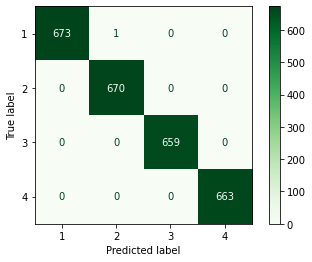

In [28]:
plot_confusion_matrix(log, X_test_sc, y_test, cmap = 'Greens');

------

-------
## **Validating with another city (Seattle)**

In [49]:
sea_listings = pd.read_csv('../data/seattle_listings_cleaned.csv')

In [50]:
sea_listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,2318,2021-09-25,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...",2536,Megan,2008-08-26,3,100.0,0,...,1,0,0,0.61,2.5,0,36,8,1,3
1,6606,2021-09-25,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...",14942,Joyce,2009-04-26,3,100.0,0,...,1,0,0,2.42,1.0,0,24,5,1,1


In [51]:
sea_listings['neighborhood'].value_counts()

Belltown               867
Broadway               835
University District    625
Fremont                623
Wallingford            572
                      ... 
Holly Park              21
Windermere              20
Meadowbrook             16
Industrial District      4
Sand Point               2
Name: neighborhood, Length: 89, dtype: int64

In [52]:
sea_listings['room_type'].value_counts()

Entire home/apt    13384
Private room        2571
Shared room           64
Name: room_type, dtype: int64

In [53]:
# preprocessing to make sure desired feature columns are numerical

# dummify neighborhood, property type, and room type columns
print(sea_listings.shape)
sea_listings_dummy = pd.get_dummies(sea_listings, columns = ['neighborhood','property_type','room_type'], drop_first = True)


sea_listings_dummy.shape

(16019, 52)


(16019, 192)

In [54]:
features = [col for col in sea_listings_dummy._get_numeric_data().columns]

# define X and y
X_sea = sea_listings_dummy[features]
y_sea = sea_listings_dummy['rating_target']

X_sea_train, X_sea_test, y_sea_train, y_sea_test = train_test_split(X_sea, y_sea, random_state=42)

In [74]:
print(X_sea_train.shape)
print(X_sea_test.shape)

(12014, 182)
(4005, 182)


In [45]:
# establishing the baseline accuracy
print(y_sea.value_counts())
print('*'*45)
print(y_sea.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y_sea.value_counts(normalize=True))[1]*100, 2)}%')


1    4144
2    4066
3    3973
4    3836
Name: rating_target, dtype: int64
*********************************************
1    0.258693
2    0.253824
3    0.248018
4    0.239466
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 25.87%


In [58]:
ss = StandardScaler()
X_sea_train_sc = ss.fit_transform(X_sea_train)
X_sea_test_sc = ss.transform(X_sea_test)

In [59]:
log2 = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log2.fit(X_sea_train_sc, y_sea_train)

print(log2.score(X_sea_train_sc, y_sea_train))
print(log2.score(X_sea_test_sc, y_sea_test))

cross_val_score(log2, X_sea_train_sc, y_sea_train).mean()

1.0
1.0


0.9998335414065751

In [72]:
# precision score for Seattle
y_sea_preds = log2.predict(X_sea_test_sc)
print(precision_score(y_sea_test, y_sea_preds, average='micro'))
precision_score(y_sea_test, y_sea_preds, average='macro')

1.0


1.0

-------
## **Validating with another city (San Francisco)**

In [60]:
sf_listings = pd.read_csv('../data/sf_listings_cleaned.csv')

In [61]:
sf_listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,958,2021-09-02,"Bright, Modern Garden Unit - 1BR/1BTH",Please check local laws re Covid before you re...,1169,Holly,2008-07-31,3,91.0,1,...,1,0,0,3.50,1.0,0,34,5,1,3
1,5858,2021-09-01,Creative Sanctuary,<b>The space</b><br />We live in a large Victo...,8904,Philip And Tania,2009-03-02,2,70.0,0,...,1,0,0,0.77,1.0,0,16,5,1,3


In [62]:
sf_listings['neighborhood'].value_counts()

Downtown/Civic Center    1593
Mission                  1361
Western Addition          987
South of Market           817
Bernal Heights            783
Castro/Upper Market       761
Haight Ashbury            711
Outer Sunset              708
Nob Hill                  634
Noe Valley                590
Marina                    435
Inner Richmond            394
Outer Richmond            384
Potrero Hill              382
Bayview                   371
Russian Hill              360
North Beach               343
Pacific Heights           337
Inner Sunset              336
Excelsior                 318
Outer Mission             289
Parkside                  285
Financial District        283
Ocean View                282
Chinatown                 269
West of Twin Peaks        241
Visitacion Valley         148
Lakeshore                 143
Glen Park                 138
Crocker Amazon            134
Twin Peaks                127
Presidio Heights           63
Seacliff                   32
Diamond He

In [63]:
sf_listings['room_type'].value_counts()

Entire home/apt    9749
Private room       4941
Shared room         231
Hotel room          182
Name: room_type, dtype: int64

In [64]:
# preprocessing to make sure desired feature columns are numerical

# dummify neighborhood, property type, and room type columns
print(sf_listings.shape)
sf_listings_dummy = pd.get_dummies(sf_listings, columns = ['neighborhood','property_type','room_type'], drop_first = True)


sf_listings_dummy.shape

(15103, 52)


(15103, 146)

In [65]:
features = [col for col in sf_listings_dummy._get_numeric_data().columns]

# define X and y
X_sf = sf_listings_dummy[features]
y_sf = sf_listings_dummy['rating_target']

X_sf_train, X_sf_test, y_sf_train, y_sf_test = train_test_split(X_sf, y_sf, random_state=42)

In [75]:
print(X_sf_train.shape)
print(X_sf_test.shape)

(11327, 136)
(3776, 136)


In [67]:
# establishing the baseline accuracy
print(y_sf.value_counts())
print('*'*45)
print(y_sf.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y_sf.value_counts(normalize=True))[4]*100, 2)}%')


4    5771
3    3152
2    3119
1    3061
Name: rating_target, dtype: int64
*********************************************
4    0.382110
3    0.208700
2    0.206515
1    0.202675
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 38.21%


In [68]:
ss = StandardScaler()
X_sf_train_sc = ss.fit_transform(X_sf_train)
X_sf_test_sc = ss.transform(X_sf_test)

In [69]:
log3 = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log3.fit(X_sf_train_sc, y_sf_train)

print(log3.score(X_sf_train_sc, y_sf_train))
print(log3.score(X_sf_test_sc, y_sf_test))

cross_val_score(log3, X_sf_train_sc, y_sf_train).mean()

1.0
0.9997351694915254


1.0

In [73]:
# precision score for San Francisco
y_sf_preds = log3.predict(X_sf_test_sc)
print(precision_score(y_sf_test, y_sf_preds, average='micro'))
precision_score(y_sf_test, y_sf_preds, average='macro')

0.9997351694915254


0.9996859296482412

#### *Model performs well for additional cities, which have more observations to train on.
-------
-------